<a href="https://colab.research.google.com/github/Hm-source/CNN_reports/blob/main/number_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "rock_paper_scissors",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete371F3E/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete371F3E/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [3]:
rrr, info = tfds.load("rock_paper_scissors",as_supervised=True, with_info=True)
class_names = info.features["label"].names
class_names

['rock', 'paper', 'scissors']

In [4]:
n_classes = info.features["label"].num_classes

In [5]:
dataset_size = info.splits["train"].num_examples
dataset_size

2520

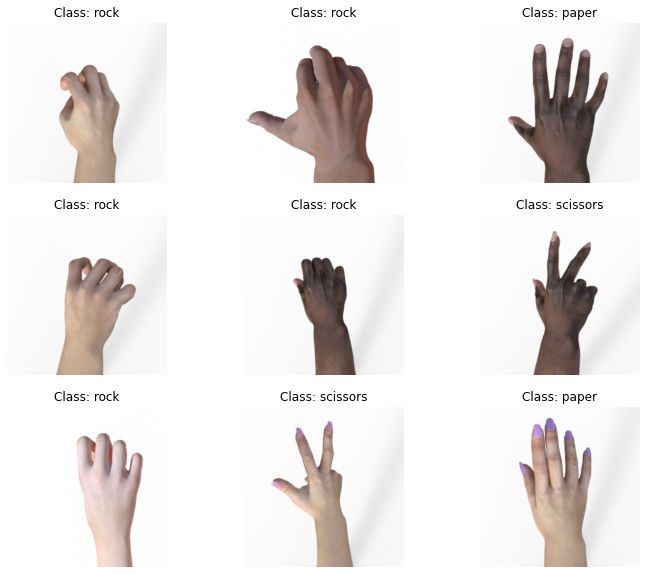

In [6]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [7]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [8]:
from functools import *

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    return resized_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat(3)
#train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [9]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=5, activation='softmax'),
])

In [10]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

from keras.callbacks import EarlyStopping

early_stopping = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5)]

history = model.fit(train_set, validation_data=valid_set, epochs = 40, callbacks = [early_stopping])

Epoch 1/40
178/178 [==============================] - 62s 247ms/step - loss: 7.3593 - accuracy: 0.3834 - val_loss: 0.1547 - val_accuracy: 0.9365
Epoch 2/40
178/178 [==============================] - 44s 239ms/step - loss: 0.1852 - accuracy: 0.9330 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/40
178/178 [==============================] - 43s 233ms/step - loss: 0.6758 - accuracy: 0.9032 - val_loss: 0.1749 - val_accuracy: 0.9683
Epoch 4/40
178/178 [==============================] - 43s 230ms/step - loss: 33.5905 - accuracy: 0.7333 - val_loss: 0.5147 - val_accuracy: 0.7328
Epoch 5/40
178/178 [==============================] - 43s 229ms/step - loss: 0.1756 - accuracy: 0.9319 - val_loss: 6.1488e-04 - val_accuracy: 1.0000
Epoch 6/40
178/178 [==============================] - 43s 230ms/step - loss: 0.0389 - accuracy: 0.9864 - val_loss: 3.8350e-04 - val_accuracy: 1.0000
Epoch 7/40
178/178 [==============================] - 43s 230ms/step - loss: 0.0291 - accuracy: 0.9914 - val_loss: 6.0434

In [12]:
model.evaluate(test_set)

8/8 [==============================] - 2s 266ms/step - loss: 1.1087 - accuracy: 0.3135


[1.1086939573287964, 0.3134920597076416]

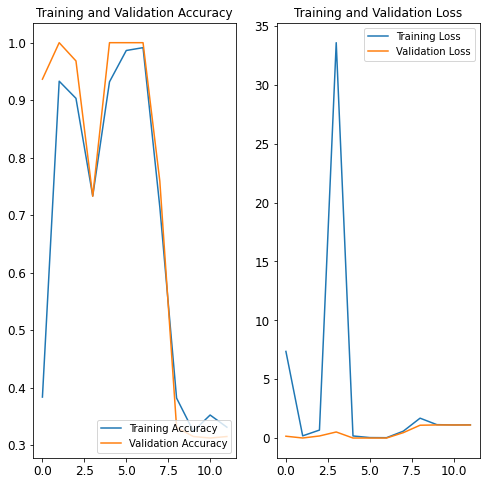

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 12
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()